# Semantic Segmentation of Remote Sensing imagery with Deep Learning

In this tutorial, we will be training and validating a deep learning (DL) model for semantic image segmentation (*i.e.*, pixel-wise classification) of remote sensing imagery. This tutorial contains the following entities:


*   Dataset: [ISPRS Vaihingen](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-vaihingen/), 9cm resolution, IR-R-G + DSM + nDSM
*   Model: [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28), a high-performing model for semantic image segmentation. U-Net was originally proposed for grayscale medical images, but we will adapt it to work on our remote sensing images with six bands.
*   DL library: [PyTorch](https://pytorch.org/), developed by facebook and one of the most popular out there.

Let us first install some required dependencies.

In [10]:
# PyTorch
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

# for downloading files from Google drive
!pip install gdown

# a nice progress bar
!pip install tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1MB 56.1MB/s eta 0:00:21tcmalloc: large alloc 1147494400 bytes == 0x5612005c2000 @  0x7f1a0fcd7615 0x5611c76cfcdc 0x5611c77af52a 0x5611c76d2afd 0x5611c77c3fed 0x5611c7746988 0x5611c77414ae 0x5611c76d43ea 0x5611c77467f0 0x5611c77414ae 0x5611c76d43ea 0x5611c774332a 0x5611c77c4e36 0x5611c7742853 0x5611c77c4e36 0x5611c7742853 0x5611c77c4e36 0x5611c7742853 0x5611c77c4e36 0x5611c78473e1 0x5611c77a76a9 0x5611c7712cc4 0x5611c76d3559 0x5611c77474f8 0x5611c76d430a 0x5611c77423b5 0x5611c77417ad 0x5611c76d43ea 0x5611c77423b5 0x5611c76d430a 0x5611c77423b5
     |█████████████████               | 1055.7MB 1.4MB/s eta 0:11:16tcmalloc: large alloc 1434370048 bytes == 0x561244c18000 @  0x7f1a0fcd7615 0x5611c76cfcdc 0x5611c77af52a 0x5611c76d2afd 0x5611c77c3fed 0x5611c7746988 0x5611c77414ae 0x5611c76d43ea 0x5611c77467f0 0x5611c77414ae 0x5611c76d43ea 0x5611c774332a 0x5611c77c4e36 0x5611c7742853 

## Theoretical basics behind deep learning model training

The basic ingredients for DL learning models are very similar to more conventional machine learning (ML) models and include:


*   A dataset of data (X) and label (Y) pairs, split into disjoint training and validation subsets;
*   A DL model f: X → Y;
*   A criterion that determines how well the model performs, called the Loss function: L(Y, ^Y). The standard for classification (incl. semantic segmentation) is the Softmax-Cross Entropy loss, which we will use below;
*   An optimizer that updates the model's parameters during training.


Unlike conventional ML methods like random forest, DL models adapt to the data in small steps by following the gradient of the loss to the next possible minimum, done via [backpropagation](https://labs.utdallas.edu/app/uploads/sites/71/2020/12/BackpropagationTheBasicTheory.pdf). The model basically follows the direction of steepest descent towards the minimum of the loss value. But we don't just want to apply the gradients as-is, but dampen their effect to only progress in small steps. This is done via the **learning rate**, a hyperparameter to be set during training.
All in all, this means that we need several passes over the full training set to achieve the best possible performance. A single pass over the dataset is called an **epoch**.

Finally, even if we have a huge training dataset, it might not be enough to make the model learn all data variability. What we can do to this end is to artificially increase our dataset by generating more training samples. For example, if we have a remote sensing image, we can rotate and/or mirror it (together with the labels) and obtain a "new" image. This is called **data augmentation** and is used in virtually every DL model. In this tutorial, we omit data augmentation for brevity reasons.


---

We will implement each of the ingredients below.

# Load dataset
Let's start by loading our dataset. In PyTorch, this is best achieved with a Dataset class that loads data-label pairs. In our case, these are image tiles and segmentation masks.
However, datasets for DL models are usually so big that we cannot store them completely in memory. For this reason, we only store the file names for the images and segmentation masks and load the actual images whenever needed. This is done in the `__getitem__` function as you will see below.

In [35]:
import torch
from torch.utils.data import dataset
import torchvision.transforms as T      # transformations that can be used e.g. for data conversion or augmentation
import numpy as np
from PIL import Image


class VaihingenDataset(dataset.Dataset):
    '''
        Custom Dataset class that loads images and ground truth segmentation
        masks from a directory.
    '''

    # image statistics, calculated in advance as averages across the full
    # training data set
    IMAGE_MEANS = (
        (121.03431026287558, 82.52572736507886, 81.92368178210943),     # IR-R-G tiles
        (285.34753853934154),                                           # DSM
        (31.005143030549313)                                            # nDSM
    )
    IMAGE_STDS = (
        (54.21029197978022, 38.434924159900554, 37.040640374137475),    # IR-R-G tiles
        (6.485453035150256),                                            # DSM
        (36.040236155124326)                                            # nDSM
    )

    def __init__(self, data_root):
        '''
            Dataset class constructor. Here we initialize the dataset instance
            and retrieve file names (and other metadata, if present) for all the
            images and labels (ground truth semantic segmentation maps).
        '''
        super().__init__()

        self.data_root = data_root

        # find all images. In our case they are listed in a CSV file called
        # "fileList.csv" under the "data_root"
        with open(os.path.join(self.data_root, 'fileList.csv'), 'r') as f:
            lines = f.readlines()
        
        # parse CSV lines into data tokens: first column is the label file, the
        # remaining ones are the image files
        self.data = []
        for line in lines[1:]:      # skip header
            self.data.append(line.strip().split(','))


    def __len__(self):
        '''
            This function tells the Data Loader how many images there are in
            this dataset.
        '''
        return len(self.data)

    
    def __getitem__(self, idx):
        '''
            Here's where we load, prepare, and convert the images and
            segmentation mask for the data element at the given "idx".
        '''
        item = self.data[idx]

        # load segmentation mask (remember: first column of CSV file)
        labels = Image.open(os.path.join(self.data_root, 'labels', item[0]))
        labels = np.array(labels, dtype=np.int64)   # convert to NumPy array temporarily

        # load all images (remaining columns of CSV file)
        images = [Image.open(os.path.join(self.data_root, 'images', i)) for i in item[1:]]

        # NOTE: at this point it would make sense to perform data augmentation.
        # However, the default augmentations built-in to PyTorch (resp.
        # Torchvision) (i.) only support RGB images; (ii.) only work on the
        # images themselves. In our case, however, we have multispectral data
        # and need to also transform the segmentation mask.
        # This is not difficult to do, but goes beyond the scope of this tutorial.
        # For the sake of brevity, we'll leave it out accordingly.
        # What we will have to do, however, is to normalize the image data.
        for i in range(len(images)):
            img = np.array(images[i], dtype=np.float32)                 # convert to NumPy array (very similar to torch.Tensor below)
            img = (img - self.IMAGE_MEANS[i]) / self.IMAGE_STDS[i]      # normalize
            images[i] = img

        # finally, we need to convert our data into the torch.Tensor format. For
        # the images, we already have a "ToTensor" transform available, but we
        # need to concatenate the images together.
        tensors = [T.ToTensor()(i) for i in images]
        tensors = torch.cat(tensors, dim=0).float()         # concatenate along spectral dimension and make sure it's in 32-bit floating point

        # For the labels, we need to convert the PIL image to a torch.Tensor.
        labels = torch.from_numpy(labels).long()            # labels need to be in 64-bit integer format

        return tensors, labels

And now, we can call this dataset through a PyTorch `DataLoader`. This is a helper class that allows loading images and labels efficiently, with multi-threading, on the CPU, while the model is training along on the GPU.

In [39]:
from torch.utils.data import dataloader


def load_dataset(data_root, split='train', batch_size=8):
    
    # initialize dataset
    dataset = VaihingenDataset(f'{data_root}/{split.lower()}')

    # initialize and return Data Loader
    dataLoader = dataloader.DataLoader(
        dataset,
        batch_size=batch_size,              # define your batch size here
        shuffle=(split=='train'),           # randomize image order (for training only)
        num_workers=2                       # multi-threading for maximum performance when loading data
    )
    return dataLoader

Before being able to do so, however, we actually need our data. We cannot just feed huge images into a DL model, or our GPU will go out of memory. Instead, we want to split our remote sensing imagery and segmentation masks (ground truth) into smaller paches (say, 800x600 pixels) and process each one individually. I have prepared this for you; all we need to do is to download the data.

In [6]:
# download prepared Vaihingen dataset
!gdown --id 1S8oCD1fK4_l2L6lYwuHOHcNtKhRYg19b

!tar -xf /content/vaihingen_512x512_full.tar.gz
data_root = '/content/dataset_512x512_full'

Downloading...
From: https://drive.google.com/uc?id=1S8oCD1fK4_l2L6lYwuHOHcNtKhRYg19b
To: /content/vaihingen_512x512_full.tar.gz
853MB [00:04, 180MB/s]


# Create DL model

Now, we have to define how our model works. We basically need to tell PyTorch what a U-Net is. This involves:

*   which layers (and layer parameters) it has,
*   in which order the layers are to be executed (the `forward` pass).

Luckily, we do not need to implement the backward pass and all the intermediate gradients – PyTorch does this for us, all automatically in the background!

Like for the dataset, we will implement U-Net as a dedicated class that PyTorch understands.


In [13]:
import torch.nn as nn     # Neural Network functionality of PyTorch


class UNet(nn.Module):
    '''
        Simple U-Net definition in PyTorch.
        Adapted and modified from https://github.com/usuyama/pytorch-unet.
    '''

    def __init__(self, num_classes, num_input_channels=3):
        '''
            Constructor. Here, we define the layers this U-Net class will
            contain.
        '''
        super().__init__()
        
        self.dconv_down1 = UNet.double_conv(num_input_channels, 64)     # allow multispectral inputs
        self.dconv_down2 = UNet.double_conv(64, 128)
        self.dconv_down3 = UNet.double_conv(128, 256)
        self.dconv_down4 = UNet.double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_up3 = UNet.double_conv(256 + 512, 256)
        self.dconv_up2 = UNet.double_conv(128 + 256, 128)
        self.dconv_up1 = UNet.double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, num_classes, 1)                  # map to number of classes
    
    @staticmethod
    def double_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        ) 
        
    def forward(self, x):
        '''
            Definition of the forward pass. In the constructor above, we defined
            what layers the model has, here we specify in which order and on
            what inputs they will be used.
        '''
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)        # note that we now concatenate intermediate inputs. These are the skip connections present in U-net
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)        # same here... 

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)        # ...and here
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

Again, all that is left to do is to create a function that initializes a fresh U-Net for us:

In [50]:
def load_model(num_classes, num_input_channels):
    model = UNet(num_classes, num_input_channels)
    return model

# Optimizer

As said above, this is the entity that modifies our U-Net's parameters according to the gradients and learning rate. Multiple optimizers exist, but we opt for the classical one, the **Stochastic Gradient Descent** (SGD). This requires the following inputs:


*   The U-Net's parameters (learnable weights, biases, etc.);
*   A learning rate value;
*   Optionally, a **weight decay** value. Weight decay is a form of regularization. Remember how ML models can overfit if their learnable parameters can become arbitrarily big? Weight decay prevents exactly this from happening by restricting DL model parameters to not grow too large. Like the learning rate, the weight decay is a hyperparameter that has to be set manually.

In [15]:
import torch.optim      # implements all kinds of optimizer types


def setup_optimizer(model, learning_rate, weight_decay):
    optimizer = torch.optim.SGD(
        model.parameters(),         # tell the optimizer which parameters to fine-tune
        lr=learning_rate,
        weight_decay=weight_decay
    )
    return optimizer

# Scheduler

As said before, the learning rate modulates the gradients and makes sure model update steps are taken gently and appropriately.
However, at some point we reach such a small "valley" in the loss landscape that our learning rate becomes too big – our model parameters "jump" from one state to another and back and fail to settle. At this moment we would like to reduce the learning rate to allow the model to converge even better.

In PyTorch, the `Scheduler` is a handy tool that allows us to do just that: it counts all steps in our training loop and reduces the learning rate by a given factor (`gamma`) at one, or more, given steps (`milestones`).

In [34]:
import torch.optim.lr_scheduler


def setup_scheduler(optimizer, milestones, gamma):
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,          # the scheduler works on the optimizer directly to modify the learning rate
        milestones,         # list of integers (iterations at which a step is taken)
        gamma               # step value (e.g. 0.1 = divide learning rate by 10 at each milestone)
    )
    return scheduler

# Define training loop

Now for the main event: the training function. Here, we want to adapt the model to the training datasets with all the ingredients above (optimizer, scheduler, etc.). In pseudocode, this looks as follows:

```python
# we first set our hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
gamma = 0.1                    # reduce learning rate by factor 10...
milestones = [1000, 5000]      # ...at 1000 and 5000 iterations each

# next, we load our "ingredients"
dataset_train = load_dataset()
model = load_model()
optimizer = setup_optimizer(model.parameters(), learning_rate, weight_decay)
scheduler = setup_scheduler(optimizer, milestones, gamma)
criterion = CrossEntropyLoss()

# iterate over dataset
for epoch in num_epochs:
  
  # perform training loop
  for (images, labels) in dataset_train:

    # forward pass: run images through model & obtain output
    prediction = model(images)

    # loss value: discrepancy between prediction and true labels
    loss = criterion(prediction, labels)

    # backward pass: calculate gradients for each model parameter by backpropagataion
    loss.backward()

    # learning step: modify model parameters w.r.t. gradients and learning rate
    optimizer.step()

    # tell the scheduler we just completed an iteration, too
    scheduler.step()
```

And that's basically it! We will add some extra garnish below, such as a progress bar and bookkeeping of loss values, but other than that that's all there is. Let's implement our training function.

In [37]:
from tqdm.notebook import trange    # progress bar


def training_epoch(dataLoader, model, optimizer, scheduler, device):

    # Enable model training mode. In this mode, parameters like BatchNorm
    # statistics are updated, dropout is applied (if specified in the model),
    # etc.
    model.train()

    # Define loss function ("criterion"). We perform semantic segmentation,
    # which basically is nothing else than pixel-wise classification. The most
    # common loss function for this is the Softmax-Cross-Entropy loss, which
    # PyTorch has nicely built-in already.
    #
    # NOTE: the Vaihingen dataset contains pixels that are unlabeled. In our
    # preparation we assigned those the value 255. We can elegantly ignore
    # predictions over these pixels with the "ignore_index" parameter.
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Statistics: during training we want to monitor how well the model behaves,
    # so let's track the loss value as a running average.
    loss_total = 0.0

    # We also want to see the loss value during training. For this we use helper
    # library "tqdm" to create a progress bar.
    progressBar = trange(len(dataLoader))

    # Define the actual loop: one full pass through all images = one epoch
    for index, (data, labels) in enumerate(dataLoader):

        # Put data and labels onto the correct computation device. In PyTorch,
        # the device is a string with the following possible values (examples):
        #
        #   "cpu":      use the processor and system RAM for models
        #   "cuda":     use the first CUDA-enabled graphics card
        #   "cuda:0"    the same as "cuda"
        #   "cuda:1"    use the second GPU (if available)
        #
        # etc.
        data, labels = data.to(device), labels.to(device)

        # forward pass
        prediction = model(data)

        # calculate loss between predictions and target labels
        loss = criterion(prediction, labels)
        if not torch.isfinite(loss):
            print('debug')

        # set all gradient weights to zero. This is important to avoid unwanted
        # accumulation across batches.
        optimizer.zero_grad()

        # perform backpropagation. This stores intermediate gradient values into
        # the respective weights, but does not yet modify the model parameters.
        loss.backward()

        # now, we apply gradient values to the model parameters, w.r.t. the set
        # learning rate, weight decay, momentum, etc.
        optimizer.step()

        # also tell the learning rate scheduler that we just finished a batch.
        scheduler.step()

        # here we update our running statistics. Our loss value is in a
        # torch.Tensor on the GPU right now, so we cannot just add it to
        # "loss_total". Instead, we need to call the .item() function to
        # retrieve the value.
        loss_total += loss.item()

        # finally, let's print the current moving average of the loss on the
        # progress bar.
        progressBar.set_description(
            '[Train] Loss: {:.2f}'.format(loss_total/(index+1))     # current average of the loss value
        )
        progressBar.update(1)
    
    # And that's it! At this point we completed one training epoch.
    progressBar.close()

    # Finalize statistics
    loss_total /= len(dataLoader)

    return loss_total

# Define validation loop

We cannot just train a model, but should periodically check how well it performs. This is exactly why we create a held-out validation split on which we do not train. If the model performs well in training, but bad in validation, it overfit the training set. If it performs bad in both, it underfits.
Checking model performance on the validation set allows us to modify our hyperparameters (learning rate, data augmentation, etc.) and make the model work on the full dataset.



---

The validation loop is almost identical to the training loop, except that we don't need to optimize any model parameters.

In [18]:
def validation_epoch(dataLoader, model, device):

    # Put model into evaluation mode. Here, BatchNorm takes the learnt
    # statistics, any existing Dropout is disabled, etc.
    model.eval()

    # Again, we define the loss function, but this time only use it for
    # statistics.
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # This time, we are interested in the prediction accuracy, so in addition to
    # the loss, we also define that. Depending on your requirements you may want
    # to define more or other measurements.
    loss_total = 0.0
    oa_total = 0.0          # overall accuracy

    progressBar = trange(len(dataLoader))

    for index, (data, labels) in enumerate(dataLoader):

        # Important: here, we don't perform any backpropagation, so we don't
        # need to store any intermediate results. This not only saves a lot of
        # GPU memory, it also makes model calculations a lot faster. In PyTorch,
        # this can be done with a flag to disable gradient calculations
        # ("torch.no_grad").
        with torch.no_grad():

            # again: put data and target labels on the GPU
            data, labels = data.to(device), labels.to(device)

            # forward pass
            pred = model(data)

            # loss value
            loss = criterion(pred, labels)
            loss_total += loss.item()

            # now, our predictions consist of vectors for each class, but for
            # the calculation of the OA we need actual predicted labels. These
            # are essentially the position of the prediction with maximum value,
            # i.e., the arg max.
            labels_pred = pred.argmax(dim=1)        # dimension 1 is our classes, so we take the arg max along it

            # calculate OA
            oa = torch.mean((labels == labels_pred).float())
            oa_total += oa.item()

            # print in progress bar again
            progressBar.set_description(
                '[Val] Loss: {:.2f}, OA: {:.2f}'.format(
                    loss_total/(index+1),
                    100 * oa_total/(index+1)
                )
            )
            progressBar.update(1)
    
    progressBar.close()

    loss_total /= len(dataLoader)
    oa_total /= len(dataLoader)

    return loss_total, oa_total

# Put it all together

We now have everything, from dataset over model and optimizer to the training and validation functions. All that is left to do is to assemble the puzzle. Below, we will implement some remaining functionality, such as saving and loading trained models, but other than that that's all it takes.

Let's first define our hyperparameters…

In [45]:
num_epochs = 10
batch_size = 4
learning_rate = 0.01
weight_decay = 0.0001
scheduler_gamma = 0.1
scheduler_milestones = [500, 1000]

…and then train and validate our model:

In [48]:
data_root = '/content/dataset_512x512_full'

# initialize training and validation data loaders
dl_train = load_dataset(data_root, 'train', batch_size)
dl_val = load_dataset(data_root, 'val', batch_size)

# information on dataset. This is usually provided in a config file somewhere with the dataset.
num_classes = 6                 # Impervious, Buildings, Low Vegetation, Tree, Car, Clutter
num_input_channels = 5          # NIR, R, G, DSM, nDSM


# initialize model
model = load_model(num_classes, num_input_channels)

# initialize optimizer and learning rate scheduler
optimizer = setup_optimizer(model, learning_rate, weight_decay)
scheduler = setup_scheduler(optimizer, scheduler_milestones, scheduler_gamma)

# load saved state if exists
save_dir = 'cnn_states'
os.makedirs(save_dir, exist_ok=True)
saveStates = os.listdir(save_dir)
if len(saveStates):
    latest = max([int(s.replace('.pt', '')) for s in saveStates])
    state = torch.load(open(os.path.join(save_dir, f'{latest}.pt'), 'rb'), map_location='cpu')
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    scheduler.load_state_dict(state['scheduler'])
    epoch = state['epoch']
    print(f'Resumed model epoch {epoch}.')
else:
    epoch = 1
    print(f'Started new model.')

# move model to the GPU
device = 'cuda'
model.to(device)

# train for desired number of epochs
while epoch <= num_epochs:

    print(f'[Epoch {epoch}/{num_epochs}]')

    # train
    loss_train = training_epoch(dl_train, model, optimizer, scheduler, device)

    # validate
    loss_val, oa_val = validation_epoch(dl_val, model, device)

    # save model parameters and statistics to file
    params = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'epoch': epoch,
        'loss_train': loss_train,
        'loss_val': loss_val,
        'oa_val': oa_val
    }
    torch.save(params, open(f'{save_dir}/{epoch}.pt', 'wb'))        # "w" = "write", "b" = "binary file"
    epoch += 1

Resumed model epoch 9.
[Epoch 9/10]



[Epoch 10/10]


# Extra: Visualization

Now that we have trained our model a bit, let's see what its prediction actually looks like.

For this tutorial we'll just draw a few images from the validation set and visualize the ground truth alongside the model predictions at different epochs.

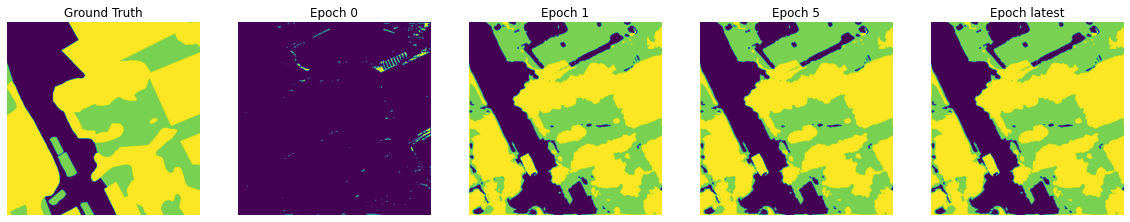

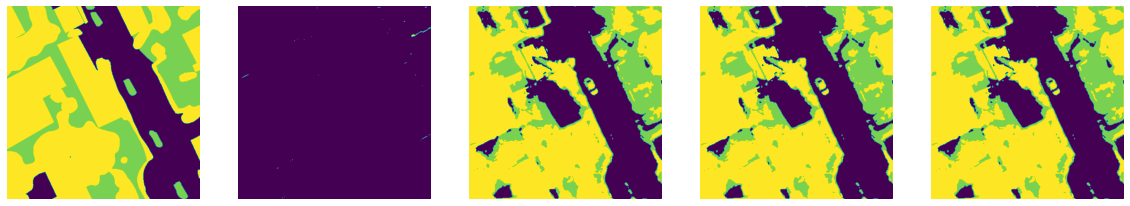

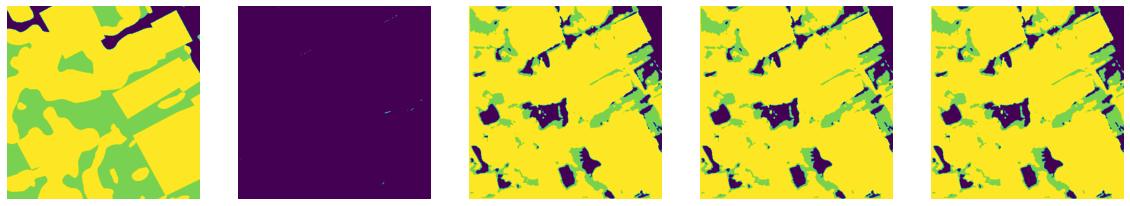

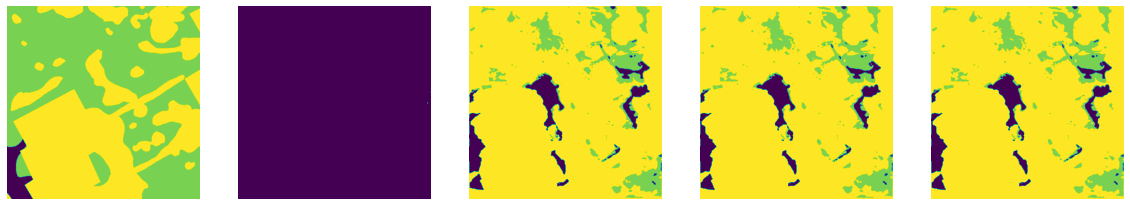

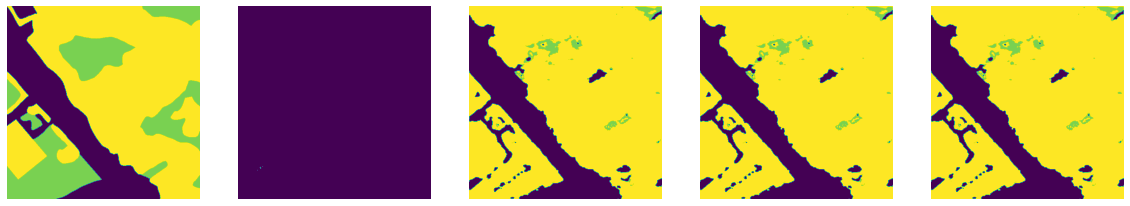

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt






def visualize(dataLoader, epochs, numImages=5):
  models = [load_model_from_state(e) for e in epochs]
  numModels = len(models)
  for idx, (data, labels) in enumerate(dataLoader):
    if idx == numImages:
      break

    _, ax = plt.subplots(nrows=1, ncols=numModels+1, figsize = (20, 15))

    # plot ground truth
    ax[0].imshow(labels[0,...].cpu().numpy())
    ax[0].axis('off')
    if idx == 0:
      ax[0].set_title('Ground Truth')

    for mIdx, model in enumerate(models):
      with torch.no_grad():
        pred = model(data.to(device))

        # get the label (i.e., the maximum position for each pixel along the class dimension)
        yhat = torch.argmax(pred, dim=1)

        # plot model predictions
        ax[mIdx+1].imshow(yhat[0,...].cpu().numpy())
        ax[mIdx+1].axis('off')
        if idx == 0:
          ax[mIdx+1].set_title(f'Epoch {epochs[mIdx]}')


def load_model_from_state(epoch='latest'):
  '''
      Little helper function to load a model at a given epoch.
  '''
  model = load_model(num_classes, num_input_channels)
  if epoch == 'latest':
    # find all saved models and load latest
    saveStates = os.listdir(save_dir)
    if len(saveStates):
      epoch = max([int(s.replace('.pt', '')) for s in saveStates])
  
  if epoch != 0:
    state = torch.load(open(os.path.join(save_dir, f'{latest}.pt'), 'rb'), map_location='cpu')
    model.load_state_dict(state['model'])
  model.to(device)
  return model


# visualize predictions for a number of epochs
dl_val_single = load_dataset(data_root, split='val', batch_size=1)

# load model states at different epochs
epochs = [0, 1, 5, 'latest']     # modify this vector according to your wishes, resp. for how many model states you have trained

visualize(dl_val_single, epochs, numImages=5)